In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
%matplotlib inline

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/650 # meters per pixel in x dimension

# Read in the saved objpoints and imgpoints
def getCalibrationParam(pickle_file):
    
    dist_pickle = pickle.load( open( pickle_file, "rb" ) )
    ret = dist_pickle["ret"]
    mtx = dist_pickle["mtx"]
    dist= dist_pickle["dist"]
    rvecs= dist_pickle["rvecs"]
    tvecs= dist_pickle["tvecs"]
    
    return ret,mtx,dist,rvecs,tvecs

def undistort(img,ret,mtx,dist,rvecs,tvecs):
    return cv2.undistort(img, mtx, dist, None, mtx)


def corner_unwarp(img):
    
    #Image height and width
    h,w = img.shape[0],img.shape[1]
    
    # Identify Rectangle instead of trapezoid that will allow curves to fall-into region
    #of interest.
    '''
    src = np.zeros((4, 2), dtype = "float32")
    src[0],src[1] = [525,450],[725,450]
    src[2],src[3] = [275,680],[925,680]

    dst = np.zeros((4, 2), dtype = "float32")    
    dst[0],dst[1] = [100,0],[1000,0]
    dst[2],dst[3] = [425,720],[775, 720]
    '''
    src = np.zeros((4, 2), dtype = "float32")
    src[0],src[1] = [560,450],[690,450]
    src[2],src[3] = [250,680],[1050,680]

    dst = np.zeros((4, 2), dtype = "float32")    
    dst[0],dst[1] = [100,0],[1000,0]
    dst[2],dst[3] = [300,720],[1000, 720] 
    
    ##Unwarp
    M = cv2.getPerspectiveTransform(src, dst) 
    MInv = cv2.getPerspectiveTransform(dst,src) 
    warped = cv2.warpPerspective(img, M,(w,h), flags=cv2.INTER_LINEAR)        

    return M,MInv,warped

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0,ksize = sobel_kernel) # Take the derivative in x
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1,ksize = sobel_kernel) # Take the derivative in y
        
    abs_sobel = np.absolute(sobel) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Apply threshold
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    
    abs_sobelx = np.absolute(cv2.Sobel(image, cv2.CV_64F, 1, 0,ksize = sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(image, cv2.CV_64F, 0, 1,ksize = sobel_kernel))
    
    abs_sobelxy = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))

    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    abs_sobelx = np.absolute(cv2.Sobel(image, cv2.CV_64F, 1, 0,ksize = sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(image, cv2.CV_64F, 0, 1,ksize = sobel_kernel))
    
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return dir_binary

print("functions created")

functions created


In [56]:
##Lane marking and curvature.
%matplotlib inline


def find_histogram_lane(binary_warped,draw_img):
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    #plt.imshow(out_img)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set the width of the windows +/- margin
    margin = 100
    left_fit,right_fit,left_fitx,right_fitx = [],[],[],[]
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    quarter_point = np.int(midpoint//2)

    leftx_base = np.argmax(histogram[:midpoint]) 
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    #print("midpoint: {} quarter_point: {}".format(midpoint,quarter_point))
    #print("left base:{} right base: {}".format(leftx_base,rightx_base))

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    #print("window_height: ".format(window_height))

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Rectangle data for visualization
    rect_box_data = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rect_box_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        

        #plt.imshow(out_img)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)


  # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    window_img = np.zeros_like(out_img)


    if len(leftx) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        if draw_img == True:
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            # Draw the windows on the visualization image
            for rect in rect_box_data:
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 

    if len(rightx) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        if draw_img == True:
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))
            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            # Draw the windows on the visualization image
            for rect in rect_box_data:
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2)                     

    if draw_img == True:
        result = cv2.addWeighted(out_img, 0.6, window_img, 0.3, 0)
        #print(result)
        return result,left_fit,right_fit,left_fitx,right_fitx,ploty,rect_box_data,histogram
    else:
        return None,left_fit,right_fit,left_fitx,right_fitx,ploty,rect_box_data,histogram        
        
def find_lane(binary_warped,draw_img,in_left_fit,in_right_fit):
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    #plt.imshow(out_img)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set the width of the windows +/- margin
    margin = 100
    left_fit,right_fit,left_fitx,right_fitx = [],[],[],[]
    
    left_fit = in_left_fit
    right_fit = in_right_fit
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    window_img = np.zeros_like(out_img)
    
    
    if len(leftx) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        if draw_img == True:
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        
    if len(rightx) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        if draw_img == True:
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))
            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
 
    if draw_img == True:
        result = cv2.addWeighted(out_img, 0.6, window_img, 0.3, 0)
        #print(result)
        return result,left_fit,right_fit,left_fitx,right_fitx,ploty,None,None
    else:
        return None,left_fit,right_fit,left_fitx,right_fitx,ploty,None,None
    
def find_position(img,pts):
    # Find the position of the car from the center
    # It will show if the car is 'x' meters from the left or right
    image_shape = img.shape
    position = image_shape[1]/2
    left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > 700)][:,1])
    right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > 700)][:,1])
    center = (left + right)/2
    # Define conversions in x and y from pixels space to meters
   
    return (position - center)*xm_per_pix

def draw_org_img(org_img,warped,left_fitx,right_fitx,ploty,MInv,curvature,position):
    
    lane_detected = True
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    #print("warped.shape: {}",format(warped.shape))
    #print("left_fitx: {}",format(left_fitx))
    #print("right_fitx: {}",format(right_fitx))
    
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, MInv, (org_img.shape[1], org_img.shape[0])) 

    # Combine the result with the original image
    img_combined = cv2.addWeighted(org_img, 1, newwarp, 0.3, 0)
    #print("img_combined.shape: {}".format(img_combined.shape))

    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(int(curvature))
    cv2.putText(img_combined,text,(400,100), font, 1,(255,255,255),2)

    if position < 0:
        text = "Vehicle is {:.2f} m left of center".format(-position)
    else:
        text = "Vehicle is {:.2f} m right of center".format(position)
    
    cv2.putText(img_combined,text,(400,150), font, 1,(255,255,255),2)

    return img_combined
       
def points_distance(p1,p2):

        x1,y1 = p1[0],p1[1]
        x2,y2 = p2[0],p2[1]
        #line_distance = np.sqrt( (x2-x1)**2 + (y2-y1)**2 ) 
        #line_distance = (x2-x1)*xm_per_pix
        line_distance = (x2-x1)#*xm_per_pix
        return line_distance

    
    
def calc_curvature(img, fitx,fity):
        # Define conversions in x and y from pixels space to meters
        y_eval = np.max(fity)

        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(fity*ym_per_pix, fitx*xm_per_pix, 2)
        curved = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        return curved
    
def calc_both_curvature(img, left_fitx,left_fity,right_fitx,right_fity):
        # Define conversions in x and y from pixels space to meters

        ly_eval = np.max(left_fity)
        ry_eval = np.max(right_fity)
        
        # Fit new polynomials to x,y in world space
        lfit_cr = np.polyfit(left_fity*ym_per_pix, left_fitx*xm_per_pix, 2)
        lcurved = ((1 + (2*lfit_cr[0]*ly_eval + lfit_cr[1])**2)**1.5) / np.absolute(2*lfit_cr[0])
        rfit_cr = np.polyfit(right_fity*ym_per_pix, right_fitx*xm_per_pix, 2)
        rcurved = ((1 + (2*rfit_cr[0]*ry_eval + rfit_cr[1])**2)**1.5) / np.absolute(2*rfit_cr[0])
        
        
        return lcurved,rcurved     
    
def two_curvature_same(left_curverad,right_curverad,threshold=0.6):
        diff = abs(left_curverad - right_curverad)/right_curverad
        #print("diff {}".format(diff))
        return diff, diff < threshold
    
print('window functions complete.')

window functions complete.


In [693]:
np.array([False])

array([False], dtype=bool)

In [64]:
class Line():
    def __init__(self,n_frames = 1,image_size = (1280,720), lane_side=None):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = None 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = [0.,0.,0.]
        #polynomial coefficients for the most recent fit
        self.current_fit = [0.,0.,0.]
        #polynomial coefficients for the most recent fit
        self.prev_fit = [0.,0.,0.]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = [0.,0.,0.]
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.lane_side = lane_side
        
        self.image_size = image_size
        self.n_frames = n_frames;
        self.current_frame = 0
        self.frame_not_detected = 0
    
    def Xstr(self,val):
        if val is None:
            return " "
        else:
            return str(val)

    def Xstr_array(self,array_val):
        if array_val is None:
            return " "
        else:
            return str(array_val.shape)
           
            
    def __str__(self):
        if self.current_frame == 0:
            output = 'Line Not Initiated '
            output += "self.lane_side:             "+str(self.lane_side)+"\n"
        else:    
            
            output = ''
            output += "self.lane_side:            "+str(self.lane_side)+"\n"
            output += "self.detected:             "+str(self.detected)+"\n"
            output += "self.recent_xfitted.shape: "+self.Xstr_array(self.recent_xfitted)+"\n"
            output += "self.allx.shape:           "+self.Xstr_array(self.allx)+"\n"
            output += "self.ally.shape:           "+self.Xstr_array(self.ally)+"\n"
            output += "self.bestx.shape:          "+self.Xstr_array(self.bestx)+"\n"
            output += "self.best_fit:             "+self.Xstr(self.best_fit)+"\n"   
            output += "self.current_fit:          "+self.Xstr(self.current_fit)+"\n"   
            output += "self.prev_fit:             "+self.Xstr(self.prev_fit)+"\n"   
            output += "self.radius_of_curvature:  "+self.Xstr(self.radius_of_curvature)+" m\n"   
            output += "self.line_base_pos:        "+self.Xstr(self.line_base_pos)+" m\n"   
            output += "self.diffs:                "+self.Xstr(self.diffs)+" m\n"   
        return output
        
    def update_points(self,x,y):

        ##Validation Section
        assert len(x) == len(y), 'x and y have to be the same size'
        
        if len(x) > 0:
            self.detected = True
            self.frame_not_detected = 0
        else:
            self.detected = False
            self.frame_not_detected += 1
            return;
        
        #print("setting x,y in Line()")
        temp_current_fit = [0.,0.,0.]
        self.allx = x
        self.ally = y
        
        temp_current_fit = np.polyfit(self.allx, self.ally, 2)
        
        diff = abs(temp_current_fit - self.best_fit)
        
        if  self.recent_xfitted is None or \
            (diff[0] > 0.001 and diff[1] > 1.0 and diff[2] > 100.):
            self.recent_xfitted = np.array([self.allx])
            self.current_frame += 1
        elif self.current_frame > self.n_frames:
            self.current_frame = 1
            #self.recent_xfitted = np.array([self.allx])
            self.recent_xfitted = self.recent_xfitted[:-self.n_frames] 
            self.recent_xfitted = np.vstack([self.recent_xfitted,self.allx])
        else:    
            #self.recent_xfitted = np.array([self.allx])
            self.recent_xfitted = np.vstack([self.recent_xfitted,self.allx])
            self.current_frame += 1
        
        self.bestx = np.mean(np.array(self.recent_xfitted),axis=0)

        if self.current_fit is None:
            self.prev_fit = temp_current_fit
            self.current_fit = temp_current_fit
        else:
            self.prev_fit = self.current_fit
            self.current_fit = temp_current_fit

        self.best_fit = np.polyfit(self.bestx, self.ally, 2)
        
        self.diffs = abs(self.current_fit - self.best_fit)

        self.radius_of_curvature = self.calc_curvature(self.allx,self.ally)
        
        self.line_base_pos = self.calc_line_to_center_dist()
        
        #print("completed update()")
        
        
    def calc_line_to_center_dist(self):
        
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/425 # meters per pixel in x dimension
        x1,y1 = self.allx[-1]*xm_per_pix, self.ally[-1]*ym_per_pix
        x2,y2 = (self.image_size[0]/2)*xm_per_pix,(self.image_size[1]/2)*ym_per_pix
        line_base_pos = np.sqrt( (x2-x1)**2 + (y2-y1)**2 ) 
        return line_base_pos
                
    def calc_curvature(self,fitx,fity):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/650 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(fity*ym_per_pix, fitx*xm_per_pix, 2)

        y_eval = np.max(fity)
        curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        
        return curverad
        

print("Line complete")

Line complete


In [112]:
from PIL import Image

def img_process(img):
    global img_cnt
    
    undist = undistort(img,ret,mtx,dist,rvecs,tvecs)
    M,MInv,warped = corner_unwarp(undist)
    
    image_rgb = warped
    r_channel = image_rgb[:,:,0]
    g_channel = image_rgb[:,:,1]
    b_channel = image_rgb[:,:,2]
    
    
    image_hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
    h_hls_channel = image_hls[:,:,0]
    l_hls_channel = image_hls[:,:,1]
    s_hls_channel = image_hls[:,:,2]
    
    ksize = 3
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(s_hls_channel, orient='x', sobel_kernel=ksize, thresh=(50, 255))
    grady = abs_sobel_thresh(s_hls_channel, orient='y', sobel_kernel=ksize, thresh=(120, 255))
    mag_binary = mag_thresh(s_hls_channel, sobel_kernel=ksize, mag_thresh=(10, 255))
    dir_binary = dir_threshold(s_hls_channel, sobel_kernel=ksize, thresh=(0,np.pi/2))
    
     #Threshold on yellow and white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image_hls, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(image_hls, lower, upper)
    # combine the mask
    mask_wy = cv2.bitwise_or(white_mask, yellow_mask)

    #filter on light channel to handle shadows on road.    
    l_hls_channel[l_hls_channel > 100] = 1
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | mask_wy == 255 | (l_hls_channel == 1)  ] = 1

    # Masking Region of interest
    region_of_interest = np.array([[[150,0],[1200,0],[1200,720],[150,720]]], np.int32)
    
    mask = np.zeros_like(combined)
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, region_of_interest, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(combined, mask)
    
    
    #im = Image.fromarray(img.astype(np.uint8))
    #im.save("./test_white1/"+str(img_cnt)+"_img.jpg")

    #im = Image.fromarray(warped.astype(np.uint8))
    #im.save("./test_white1/"+str(img_cnt)+"_warped.jpg")

    #im = Image.fromarray(combined.astype(np.uint8))
    #im.save("./test_white1/"+str(img_cnt)+"_combined.jpg")
    
    #im = Image.fromarray(masked_image.astype(np.uint8))
    #im.save("./test_white1/"+str(img_cnt)+"_masked.jpg")
    
    result,left_fit,right_fit,left_fitx,right_fitx,ploty,rect_box_data,histogram = find_histogram_lane(masked_image,True)
    #im = Image.fromarray(result.astype(np.uint8))
    #im.save("./test_white1/"+str(img_cnt)+"_result.jpg")
    #print("plot results")

    right_fit_diff = [0.,0.,0.]
    left_fit_diff = [0.,0.,0.]
    lcurved,rcurved = 0.,0.
    
    pd_thresh = 50 #Allowed threshold 40 pixels
    
    #print("length ",len(left_fitx),len(right_fitx))
    
    if len(left_fitx) > 0 and len(right_fitx) > 0:
        
        ##find if lines are almost parallel
        left_top_point = [left_fitx[100],ploty[100]]
        left_mid_point = [left_fitx[300],ploty[300]]
        left_bottom_point = [left_fitx[600],ploty[600]]

        right_top_point = [right_fitx[100],ploty[100]]
        right_mid_point = [right_fitx[300],ploty[300]]
        right_bottom_point = [right_fitx[600],ploty[600]]
        
        top_pd = points_distance(left_top_point,right_top_point)
        mid_pd = points_distance(left_mid_point,right_mid_point)
        bot_pd = points_distance(left_bottom_point,right_bottom_point)
        
        avg_pd = (top_pd+mid_pd+bot_pd)/3
        
        #print("top_pd: {} mid_pd: {} bot_pd: {} avg_pd : {}".format(top_pd,mid_pd,bot_pd,avg_pd))
        
        lcurved = calc_curvature(masked_image,left_fitx,ploty)
        rcurved = calc_curvature(masked_image,right_fitx,ploty)
        
        if  abs(top_pd - avg_pd) < pd_thresh and \
            abs(mid_pd - avg_pd) < pd_thresh and \
            abs(bot_pd - avg_pd) < pd_thresh:
            
            #print("---------Land distance within threshold-----------")
            left_lane.update_points(left_fitx,ploty)
            right_lane.update_points(right_fitx,ploty)
            #print(left_lane)
            #print(right_lane)
            #diff,curves_same = two_curvature_same(lcurved,rcurved)    
            center = 640
            left_x = left_fitx[-1]
            right_x = right_fitx[-1]
            lane_center = (right_x + left_x)/2
            pos = (center - lane_center)*xm_per_pix

            overlap_img = draw_org_img(undist,masked_image,left_lane.bestx,right_lane.bestx,ploty,MInv,rcurved,pos)
        else:    
            if left_lane.bestx is not None and right_lane.bestx is not None:
                rcurved = calc_curvature(masked_image,right_lane.bestx,ploty)
                lcurved = calc_curvature(masked_image,left_lane.bestx,ploty)

                center = 640
                left_x = left_lane.bestx[-1]
                right_x = right_lane.bestx[-1]
                lane_center = (right_x + left_x)/2
 
                pos = (center - lane_center)*xm_per_pix
                overlap_img = draw_org_img(undist,masked_image,left_lane.bestx,right_lane.bestx,ploty,MInv,rcurved,pos)
            else:
                rcurved,lcurved = 0.,0.
                pos = 0
                overlap_img = undist
    else:
        if left_lane.bestx is not None and right_lane.bestx is not None:
            rcurved = calc_curvature(masked_image,right_lane.bestx,ploty)
            lcurved = calc_curvature(masked_image,left_lane.bestx,ploty)

            center = 640
            left_x = left_lane.bestx[-1]
            right_x = right_lane.bestx[-1]
            lane_center = (right_x + left_x)/2

            pos = (center - lane_center)*xm_per_pix
            overlap_img = draw_org_img(undist,masked_image,left_lane.bestx,right_lane.bestx,ploty,MInv,rcurved,pos)
        else:
            rcurved,lcurved = 0.,0.
            pos = 0
            overlap_img = undist
    
    #plt.imshow(overlap_img)
    #plt.savefig("./test_white1/"+str(img_cnt)+"_overlap_img.jpg")
    img_cnt += 1  
    return overlap_img
    #return result,histogram, warped, combined, overlap_img,left_fitx,right_fitx,ploty
    #return result,histogram, warped, masked_image, overlap_img,left_fitx,right_fitx,ploty,undist,combined

self.lane_side:            left
self.detected:             True
self.recent_xfitted.shape: (1, 720)
self.allx.shape:           (720,)
self.ally.shape:           (720,)
self.bestx.shape:          (720,)
self.best_fit:             [  2.32524504e-02  -1.01567598e+01   1.16026153e+03]
self.current_fit:          [  2.32524504e-02  -1.01567598e+01   1.16026153e+03]
self.prev_fit:             [0.0, 0.0, 0.0]
self.radius_of_curvature:  3318.47187678 m
self.line_base_pos:        3.29310820949 m
self.diffs:                [ 0.  0.  0.] m

self.lane_side:            right
self.detected:             True
self.recent_xfitted.shape: (1, 720)
self.allx.shape:           (720,)
self.ally.shape:           (720,)
self.bestx.shape:          (720,)
self.best_fit:             [  9.78403128e-03  -1.57865909e+01   6.38731380e+03]
self.current_fit:          [  9.78403128e-03  -1.57865909e+01   6.38731380e+03]
self.prev_fit:             [0.0, 0.0, 0.0]
self.radius_of_curvature:  2651.42896245 m
self.line_base_p

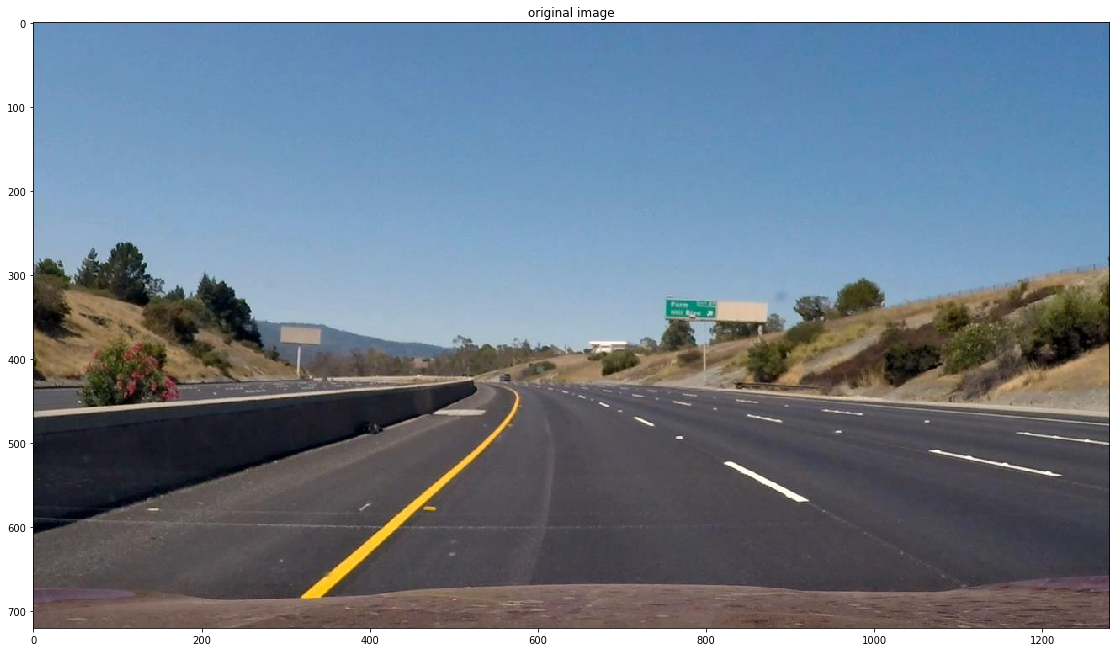

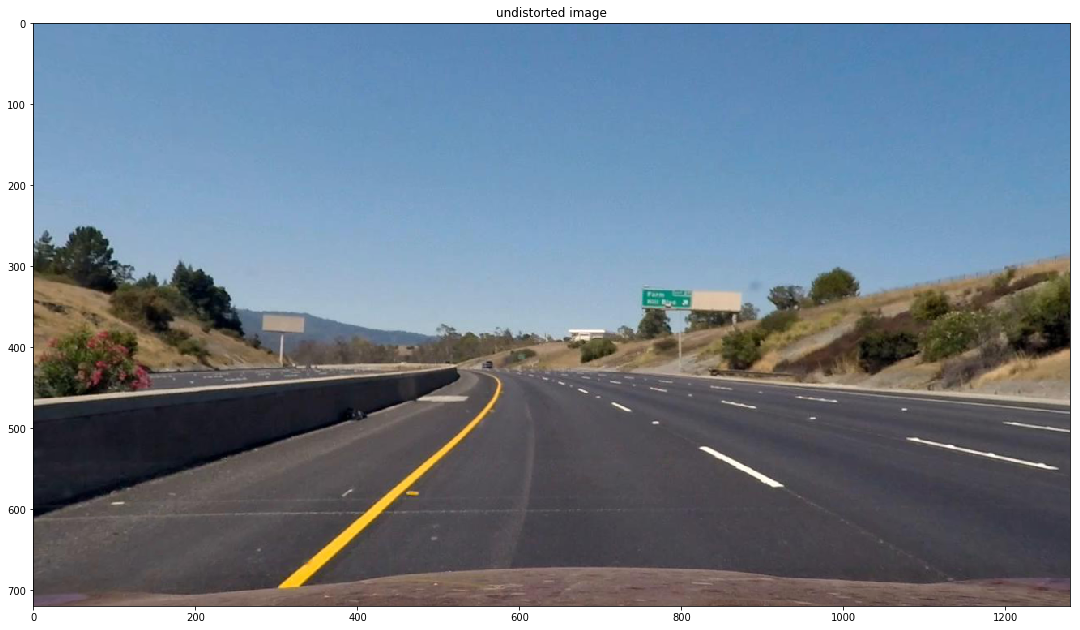

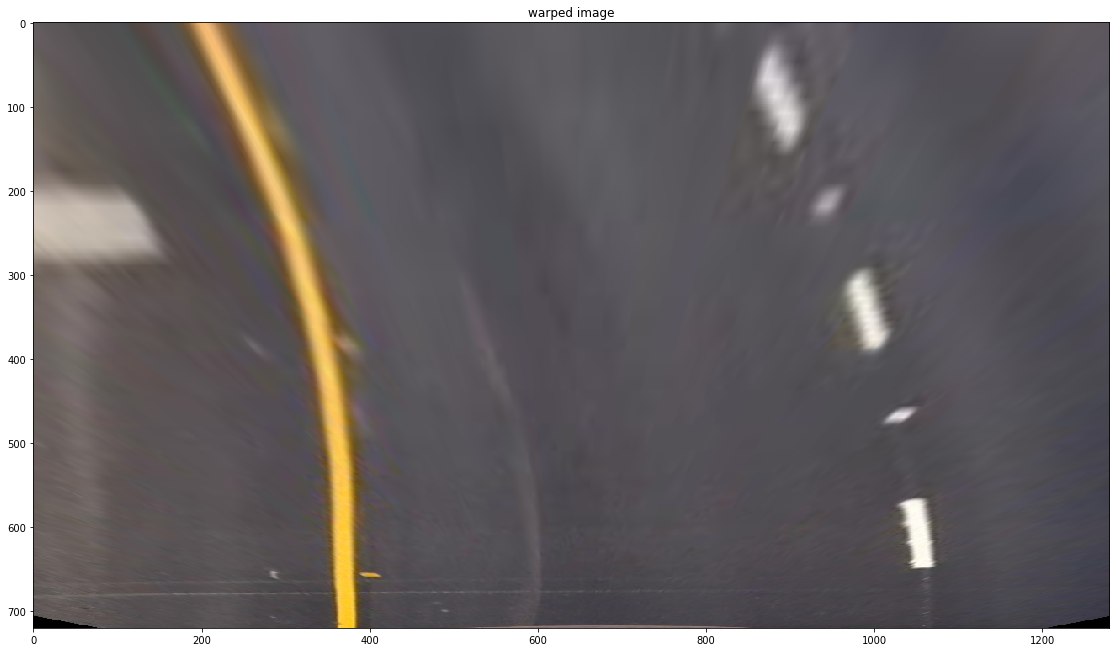

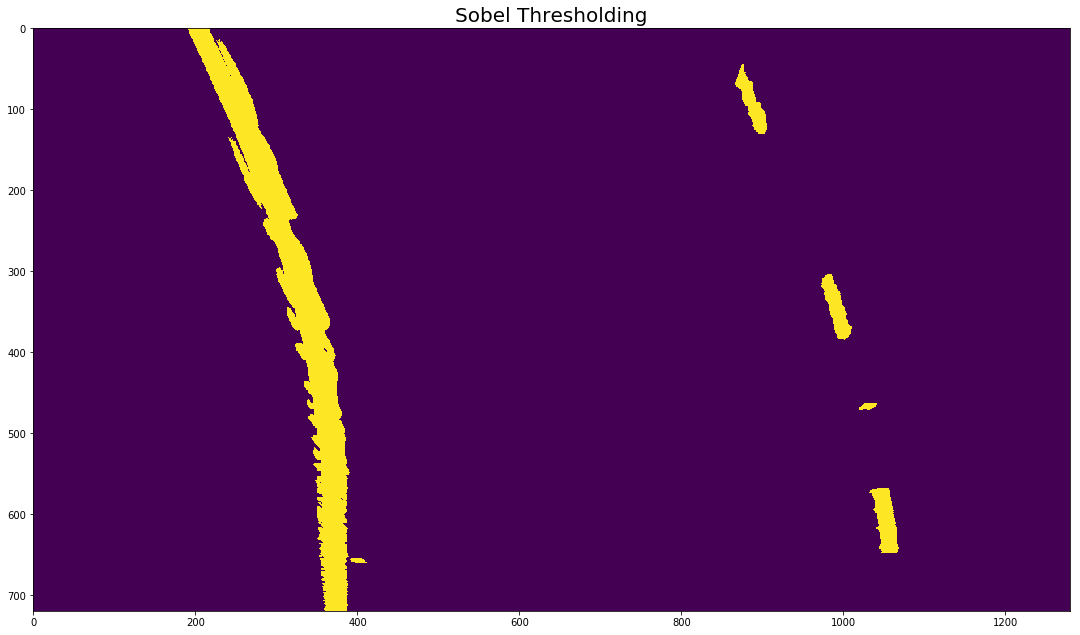

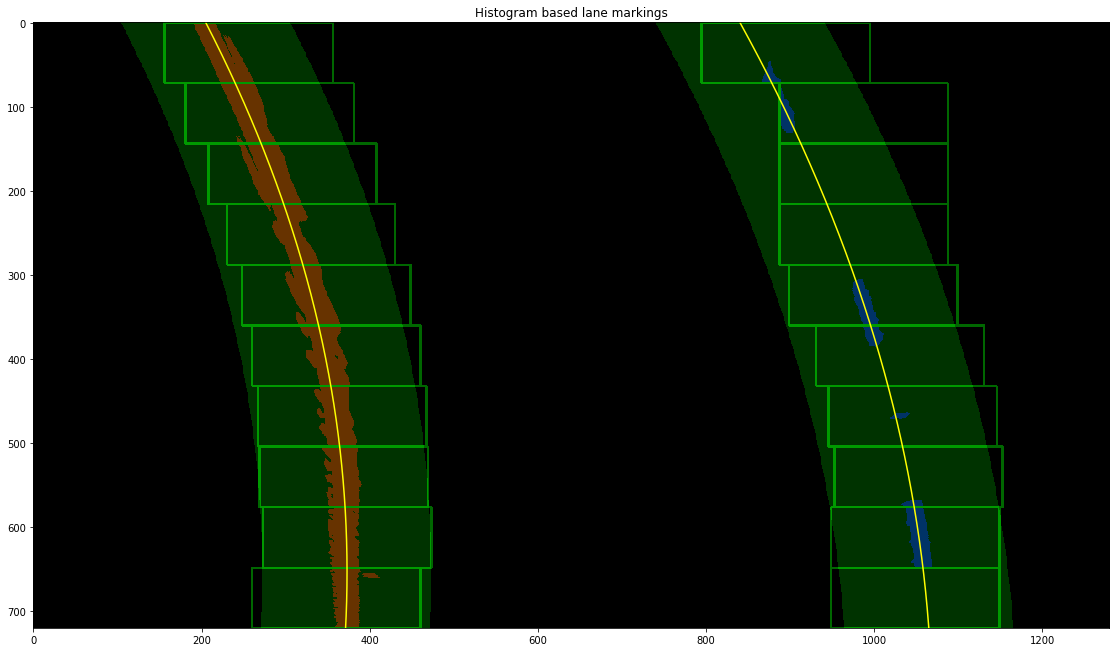

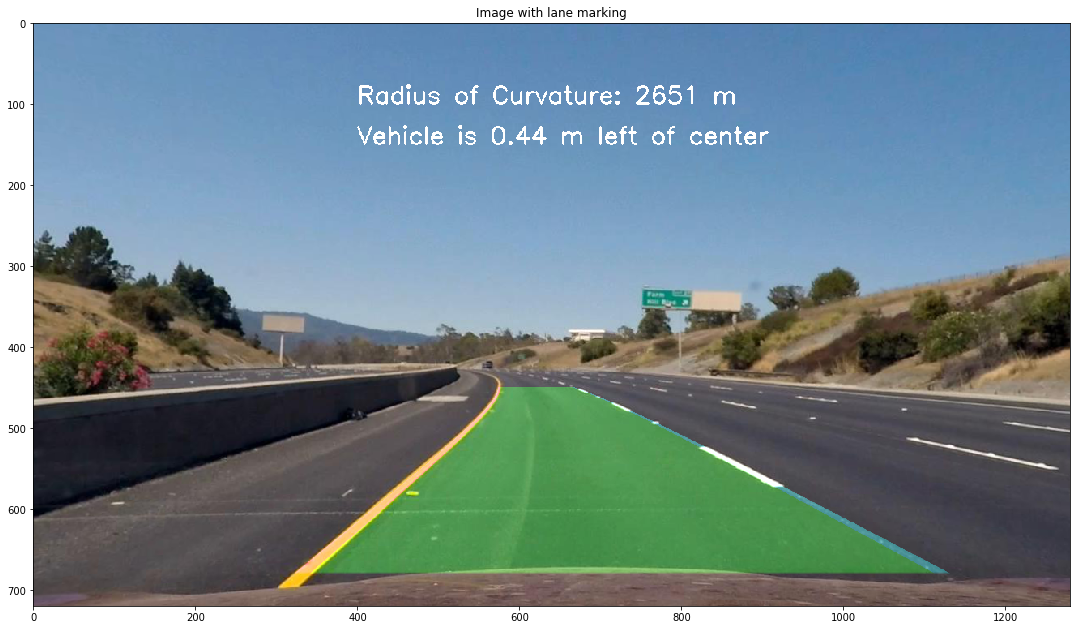

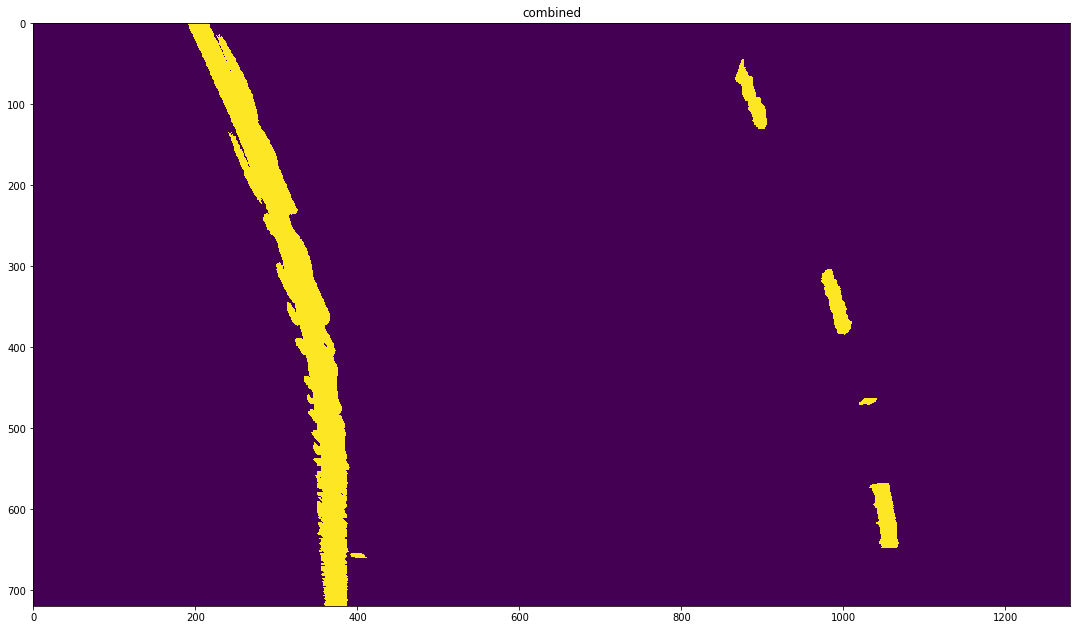

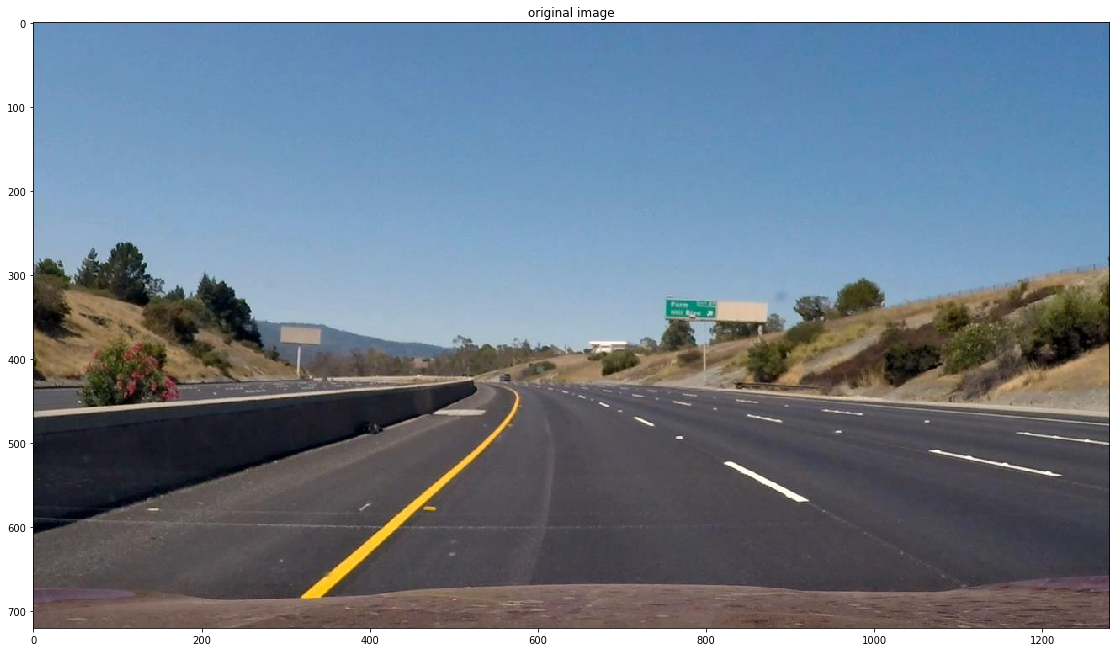

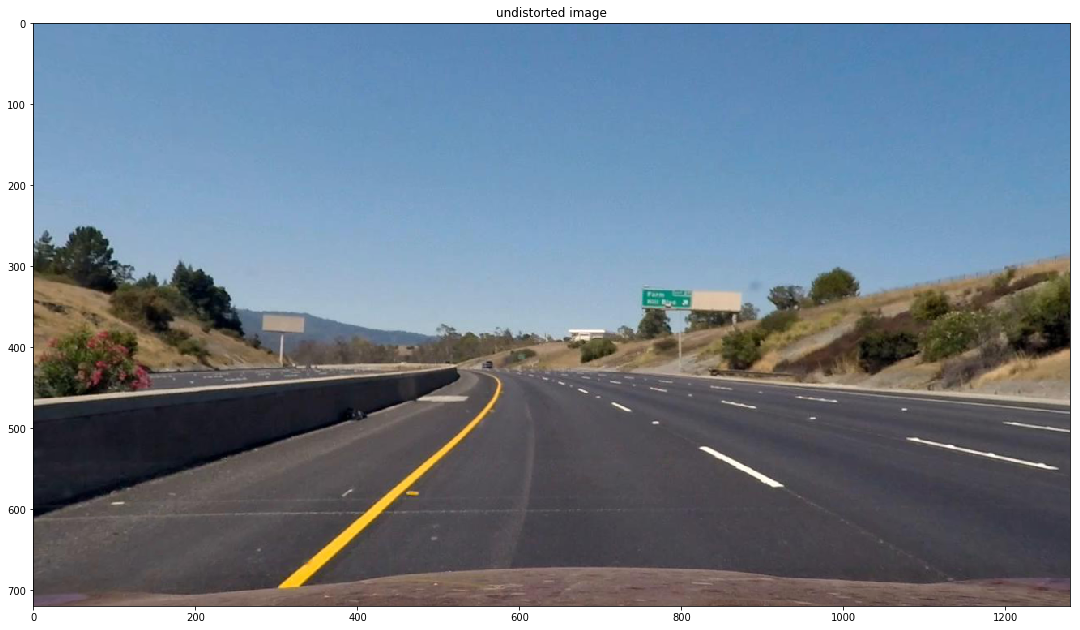

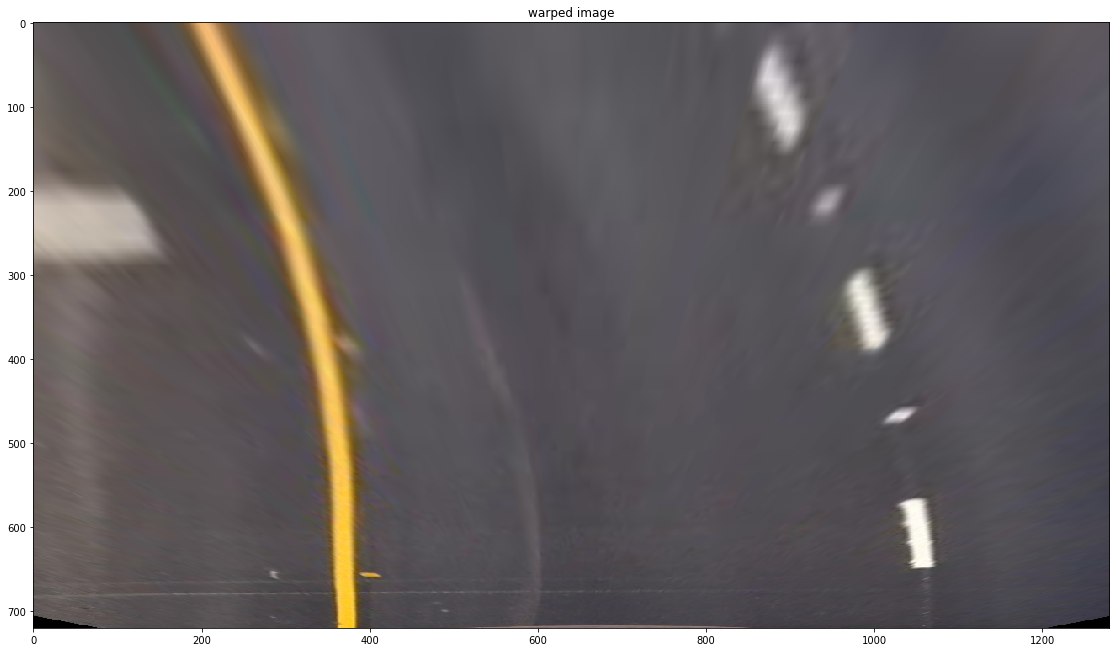

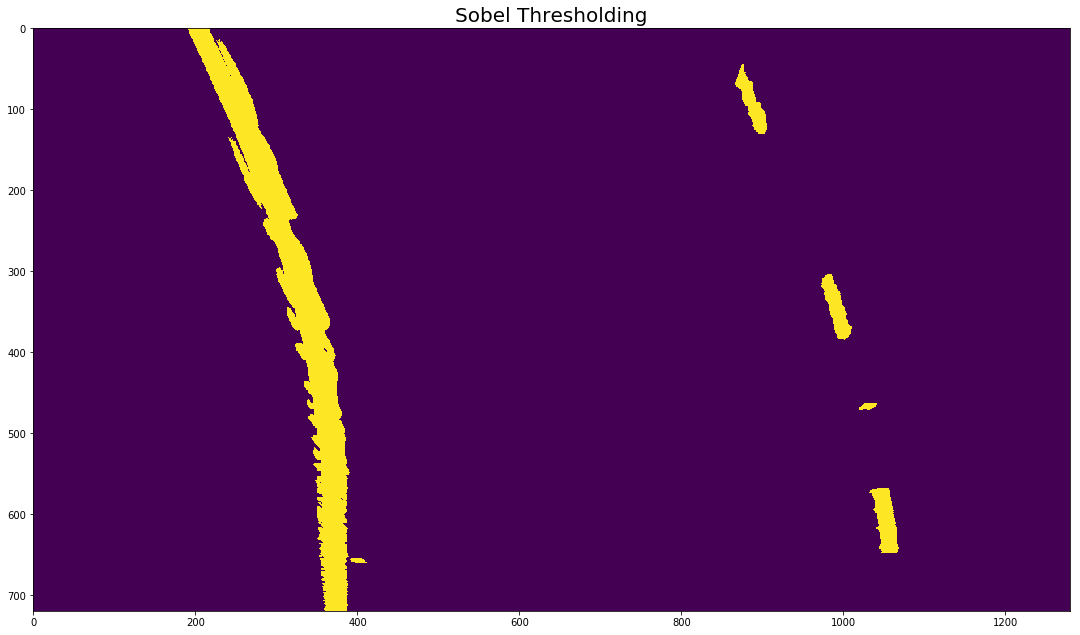

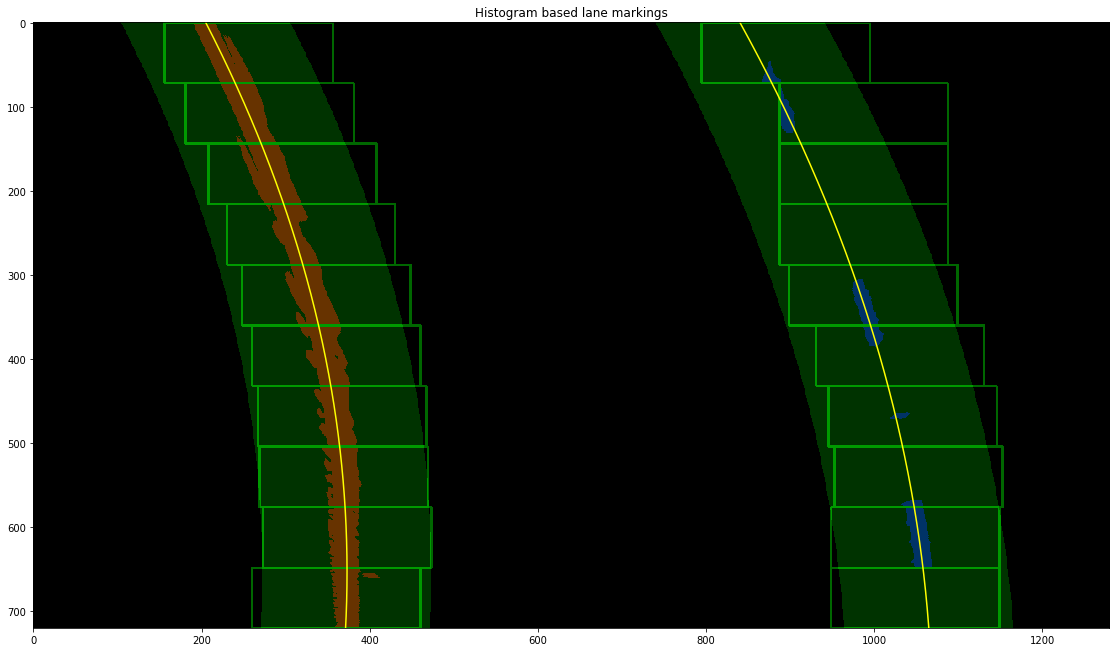

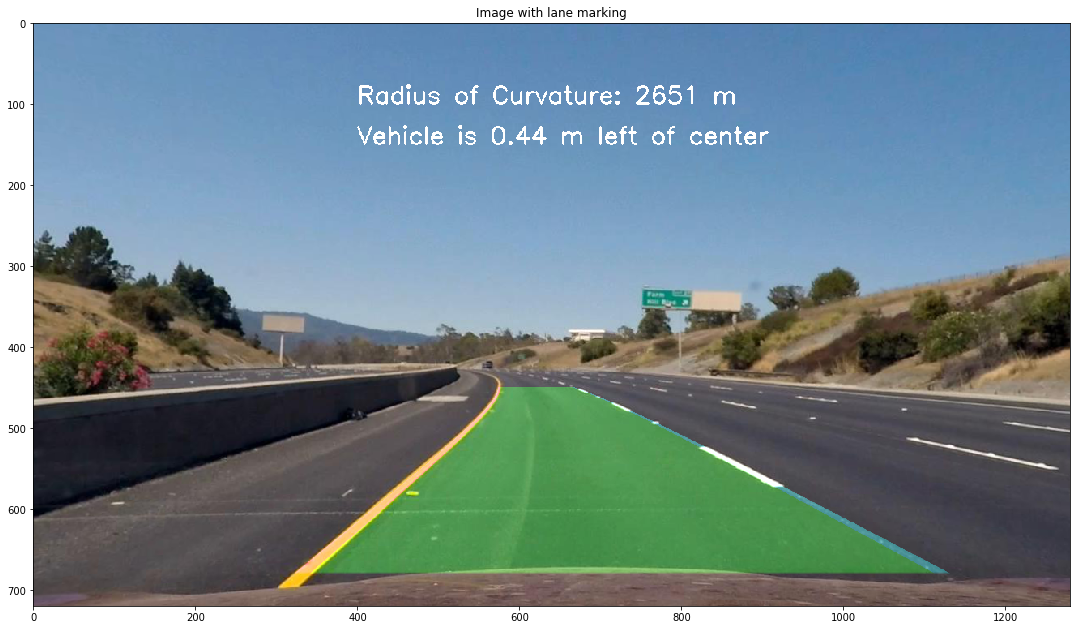

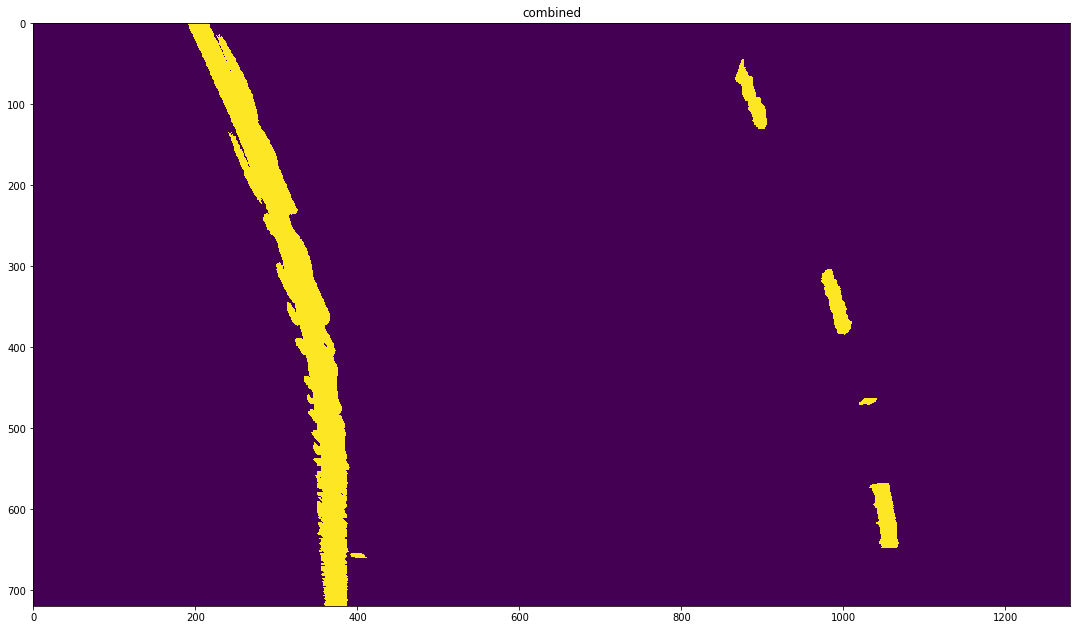

In [110]:
camera_calib_pickle_file="./camera_calibrate.p"
ret,mtx,dist,rvecs,tvecs = getCalibrationParam(camera_calib_pickle_file)
img_cnt = 1
test_img_dir = './test_images'
images = glob.glob(test_img_dir+"/*.jpg")
#images = ["./test_images/test5.jpg","./test_images/straight_lines2.jpg"]
#Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

left_lane = Line(1,(720,1280),'left')
right_lane = Line(1,(720,1280),'right')

c=1
for fname in images:
    #img = cv2.imread(fname)
    img = mpimg.imread(fname)
    result,histogram, warped,  masked_image, overlap_img,left_fitx,right_fitx,ploty,undist,combined = img_process(img)
   
    f11, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
    f11.tight_layout()
    ax1.imshow(img)
    ax1.set_title("original image")
    f12, (ax2) = plt.subplots(1, 1, figsize=(24, 9))
    f12.tight_layout()
    ax2.imshow(undist)
    ax2.set_title("undistorted image")
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    f21, (ax3) = plt.subplots(1, 1, figsize=(24, 9))
    f21.tight_layout()
    ax3.imshow(warped)
    ax3.set_title("warped image")
    f22, (ax4) = plt.subplots(1, 1, figsize=(24, 9))
    f22.tight_layout()
    ax4.imshow(masked_image)
    ax4.set_title('Sobel Thresholding', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    f31, (ax5) = plt.subplots(1, 1, figsize=(24, 9))
    f31.tight_layout()
    ax5.imshow(result)
    ax5.set_title("Histogram based lane markings")
    if len(left_fitx) > 0:
        ax5.plot(left_fitx, ploty, color='yellow')
    if len(right_fitx) > 0:    
        ax5.plot(right_fitx, ploty, color='yellow')

    f32, (ax6) = plt.subplots(1, 1, figsize=(24, 9))
    f32.tight_layout()
    ax6.imshow(overlap_img)
    ax6.set_title("Image with lane marking")
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    f33, (ax7) = plt.subplots(1, 1, figsize=(24, 9))
    f33.tight_layout()
    ax7.imshow(combined)
    ax7.set_title("combined")
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    
    f11.savefig("./output_images/new_original_"+str(c)+".jpg")
    f12.savefig("./output_images/new_undistorted_"+str(c)+".jpg")
    f21.savefig("./output_images/new_warped_"+str(c)+".jpg")
    f22.savefig("./output_images/new_sobel_"+str(c)+".jpg")
    f31.savefig("./output_images/new_histogram_"+str(c)+".jpg")
    f32.savefig("./output_images/new_lane_mark_"+str(c)+".jpg")
    
    
    c += 1


In [115]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

img_cnt = 1
#Camera Calibration parameters
camera_calib_pickle_file="./camera_calibrate.p"
ret,mtx,dist,rvecs,tvecs = getCalibrationParam(camera_calib_pickle_file)
# Set up lines for left and right
left_lane = Line(3,(720,1280),'left')
right_lane = Line(3,(720,1280),'right')
white_output = 'white.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(img_process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4











  0%|          | 0/1261 [00:00<?, ?it/s]








  0%|          | 1/1261 [00:00<07:59,  2.63it/s]








  0%|          | 2/1261 [00:00<08:07,  2.58it/s]








  0%|          | 3/1261 [00:01<07:51,  2.67it/s]








  0%|          | 4/1261 [00:01<08:03,  2.60it/s]








  0%|          | 5/1261 [00:01<07:58,  2.63it/s]








  0%|          | 6/1261 [00:02<07:58,  2.63it/s]








  1%|          | 7/1261 [00:02<08:04,  2.59it/s]








  1%|          | 8/1261 [00:03<07:42,  2.71it/s]








  1%|          | 9/1261 [00:03<07:44,  2.70it/s]








  1%|          | 10/1261 [00:03<07:28,  2.79it/s]








  1%|          | 11/1261 [00:04<07:12,  2.89it/s]








  1%|          | 12/1261 [00:04<07:38,  2.73it/s]








  1%|          | 13/1261 [00:04<08:06,  2.57it/s]








  1%|          | 14/1261 [00:05<07:52,  2.64it/s]








  1%|          | 15/1261 [00:05<07:28,  2.78it/s]








  1%|▏         | 16/1261 [00:05<07:20,  2.83it/s]








  1%|▏         | 17/126

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 8min 59s, sys: 20.9 s, total: 9min 20s
Wall time: 9min 10s


In [116]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [64]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#Camera Calibration parameters
camera_calib_pickle_file="./camera_calibrate.p"
ret,mtx,dist,rvecs,tvecs = getCalibrationParam(camera_calib_pickle_file)
# Set up lines for left and right
left_lane = Line(1,(720,1280),'left')
right_lane = Line(1,(720,1280),'right')
challenge_white_output = 'challenge_white.mp4'
challenge_clip1 = VideoFileClip("harder_challenge_video.mp4")
challenge_white_clip = challenge_clip1.fl_image(img_process) #NOTE: this function expects color images!!
%time challenge_white_clip.write_videofile(challenge_white_output, audio=False)

[MoviePy] >>>> Building video challenge_white.mp4
[MoviePy] Writing video challenge_white.mp4


100%|█████████▉| 1199/1200 [06:57<00:00,  2.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_white.mp4 

CPU times: user 6min 56s, sys: 6.42 s, total: 7min 2s
Wall time: 7min 1s


In [65]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_white_output))